# Урок 8. Снижение размерности данных 

1. Обучить любую модель классификации на датасете IRIS до применения самописного PCA (2 компоненты) и после него. Сравнить качество классификации по отложенной выборке.

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
def standard_scale(x):
    res = (x - x.mean(axis=0)) / x.std(axis=0)
    return res

In [3]:
# Загрузим игрушечный датасет из sklearn
iris = load_iris()
X = iris.data
y = iris.target
X.shape

(150, 4)

In [4]:
# Для начала отмасштабируем выборку
X = X.astype(float)

X = standard_scale(X)
X[:10]

array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
       [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
       [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ],
       [-1.50652052,  0.09821729, -1.2833891 , -1.3154443 ],
       [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ],
       [-0.53717756,  1.93979142, -1.16971425, -1.05217993],
       [-1.50652052,  0.78880759, -1.34022653, -1.18381211],
       [-1.02184904,  0.78880759, -1.2833891 , -1.3154443 ],
       [-1.74885626, -0.36217625, -1.34022653, -1.3154443 ],
       [-1.14301691,  0.09821729, -1.2833891 , -1.44707648]])

In [5]:
# Разделим датасет на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)
X_train.shape

(105, 4)

Построим дерево решений на обучающей выборке, а затем рассчитаем метрику `accuracy`.

In [6]:
tree = DecisionTreeClassifier(random_state=42, 
                              max_depth=3)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [7]:
y_train_pred_tree = tree.predict(X_train)
y_pred_tree = tree.predict(X_test)
print(f'Accuracy на обучающей выборке - {accuracy_score(y_train, y_train_pred_tree):.6f}.')
print(f'Accuracy на тестовой выборке - {accuracy_score(y_test, y_pred_tree):.6f}.')

Accuracy на обучающей выборке - 0.980952.
Accuracy на тестовой выборке - 0.977778.


Обучим дополнительно модель градиентного бустинга для классификации и также рассчитаем `accuracy`.

In [8]:
gb_model = GradientBoostingClassifier(random_state=42,
                                     learning_rate=0.01,
                                     max_depth=2)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=2, random_state=42)

In [9]:
y_train_pred_gb = gb_model.predict(X_train)
y_pred_gb = gb_model.predict(X_test)
print(f'Accuracy на обучающей выборке - {accuracy_score(y_train, y_train_pred_gb):.6f}.')
print(f'Accuracy на тестовой выборке - {accuracy_score(y_test, y_pred_gb):.6f}.')

Accuracy на обучающей выборке - 0.971429.
Accuracy на тестовой выборке - 0.955556.


Воспользуемся реализацией метода PCA, представленной в лекции, и сравним оценки `accuracy` после уменьшения размерности.

In [10]:
# Найдем собственные векторы и собственные значения
 
covariance_matrix = X_train.T @ X_train

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

In [11]:
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описываемая каждой из компонент \n{var_exp}')

# а теперь оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описываемая каждой из компонент 
[71.84272862894603, 24.170737358708212, 3.541187984681393, 0.4453460276643643]
Кумулятивная доля дисперсии по компонентам 
[ 71.84272863  96.01346599  99.55465397 100.        ]


In [12]:
# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack([eig_pairs[i][1].reshape(4,1) for i in range(2)])

# Сформируем новые матрицы "объекты-признаки"
Z_train = X_train.dot(W)
Z_test = X_test.dot(W)
Z_train.shape

(105, 2)

Обучим дерево решений на датасете уменьшенной размерности.

In [13]:
tree_pca = DecisionTreeClassifier(random_state=42,
                                  max_depth=3)
tree_pca.fit(Z_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

Теперь посмотрим как изменилось значение метрики `accuracy` на тестовом датасете, после того как мы оставили только 2 признака, которые отвечают за 96% информации.

In [14]:
y_train_pred_tree_pca = tree_pca.predict(Z_train)
y_pred_tree_pca = tree_pca.predict(Z_test)
print(f'Accuracy на обучающей выборке - {accuracy_score(y_train, y_train_pred_tree_pca):.6f}.')
print(f'Accuracy на тестовой выборке - {accuracy_score(y_test, y_pred_tree_pca):.6f}.')

Accuracy на обучающей выборке - 0.942857.
Accuracy на тестовой выборке - 0.888889.


In [15]:
np.round((1 - accuracy_score(y_test, y_pred_tree_pca)/accuracy_score(y_test, y_pred_tree))*100, 2)

9.09

Как видим в случае дерева решений метрика `accuracy` уменьшилась на 9%.

Теперь посмотрим на результаты для модели градиентного бустинга.

In [16]:
gb_model_pca = GradientBoostingClassifier(random_state=42,
                                     learning_rate=0.01,
                                     max_depth=2)
gb_model_pca.fit(Z_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=2, random_state=42)

In [17]:
y_train_pred_gb_pca = gb_model_pca.predict(Z_train)
y_pred_gb_pca = gb_model_pca.predict(Z_test)
print(f'Accuracy на обучающей выборке - {accuracy_score(y_train, y_train_pred_gb_pca):.6f}.')
print(f'Accuracy на тестовой выборке - {accuracy_score(y_test, y_pred_gb_pca):.6f}.')

Accuracy на обучающей выборке - 0.942857.
Accuracy на тестовой выборке - 0.888889.


In [18]:
np.round((1 - accuracy_score(y_test, y_pred_gb_pca)/accuracy_score(y_test, y_pred_gb))*100, 2)

6.98

Для градиентного бустинга метрика `accuracy` уменьшилась на 7% после изменения размерности датасета.

2. *Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции [numpy.linalg.svd()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html)

Для реализации понижения размерности методом главных компонент с помощью SVD нужно:
- найти сингулярное разложение $X^TX$;
- сформировать из столбцов матрицы $V$, соответствующих $d$ наибольшим сингулярным числам, матрицу весов $W$;
- получить новую матрицу "объекты-признаки", умножив исходную матрицу $X$ на матрицу весов $W$:

$$Z=XW.$$

In [19]:
def pca_svd(X, d):
    if d <= X.shape[1]:
        u, s, vh = np.linalg.svd(X.T @ X)
        W = vh[:d, :].T
        return X @ W
    else:
        print('Количество компонент не должно быть больше количества признаков в изначальном массиве.')

In [20]:
Z = pca_svd(X, 2)
Z[:10]

array([[ 2.26470281, -0.4800266 ],
       [ 2.08096115,  0.67413356],
       [ 2.36422905,  0.34190802],
       [ 2.29938422,  0.59739451],
       [ 2.38984217, -0.64683538],
       [ 2.07563095, -1.48917752],
       [ 2.44402884, -0.0476442 ],
       [ 2.23284716, -0.22314807],
       [ 2.33464048,  1.11532768],
       [ 2.18432817,  0.46901356]])

Визуализируем полученный датасет как на лекции. Отметим, что несмотря на понижение размерности, классы остались разделимы в пространстве.

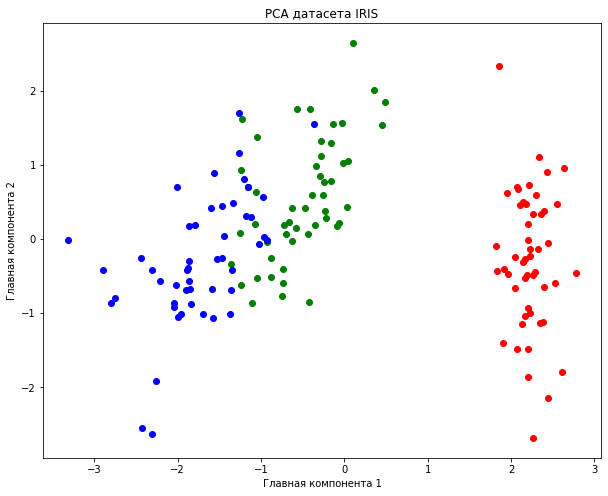

In [21]:
plt.figure(figsize=(10, 8))
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(Z[y == i, 0], Z[y == i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA датасета IRIS')
plt.show()